In [11]:
import os
import glob
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import NMF
from sklearn.preprocessing import normalize
from scipy.sparse import csr_matrix
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings("ignore")


Matplotlib is building the font cache; this may take a moment.


In [12]:
print("Loading datasets...")
train_customers = pd.read_csv('Train/train_customers.csv')
train_locations = pd.read_csv('Train/train_locations.csv')
train_orders = pd.read_csv('Train/orders.csv')
vendors = pd.read_csv('Train/vendors.csv')
test_customers = pd.read_csv('Test/test_customers.csv')
test_locations = pd.read_csv('Test/test_locations.csv')
print("Dataset shapes:")
print(f"Train customers: {train_customers.shape}")
print(f"Train locations: {train_locations.shape}")
print(f"Train orders: {train_orders.shape}")
print(f"Vendors: {vendors.shape}")
print(f"Test customers: {test_customers.shape}")
print(f"Test locations: {test_locations.shape}")
print("\n" + "="*50)
print("TRAINING CUSTOMERS INFO")
print("="*50)
print(train_customers.info())
print("\nFirst few rows:")
print(train_customers.head())

Loading datasets...
Dataset shapes:
Train customers: (34674, 8)
Train locations: (59503, 5)
Train orders: (135303, 26)
Vendors: (100, 59)
Test customers: (9768, 8)
Test locations: (16720, 5)

TRAINING CUSTOMERS INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34674 entries, 0 to 34673
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   customer_id  34674 non-null  object 
 1   gender       22520 non-null  object 
 2   dob          3046 non-null   float64
 3   status       34674 non-null  int64  
 4   verified     34674 non-null  int64  
 5   language     21099 non-null  object 
 6   created_at   34674 non-null  object 
 7   updated_at   34674 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 2.1+ MB
None

First few rows:
  customer_id gender  dob  status  verified language       created_at  \
0     TCHWPBT   Male  NaN       1         1       EN   2/7/2023 19:16   
1     ZGFSYCZ   Male  NaN 

In [13]:
print("="*50)
print("TRAINING LOCATIONS INFO")
print("="*50)
print(train_locations.info())
print("\nFirst few rows:")
print(train_locations.head())
print("\nLocation type distribution:")
print(train_locations['location_type'].value_counts())
print("\nLocation statistics:")
print(train_locations[['latitude', 'longitude']].describe())

TRAINING LOCATIONS INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59503 entries, 0 to 59502
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   customer_id      59503 non-null  object 
 1   location_number  59503 non-null  int64  
 2   location_type    32294 non-null  object 
 3   latitude         59497 non-null  float64
 4   longitude        59497 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 2.3+ MB
None

First few rows:
  customer_id  location_number location_type  latitude  longitude
0     02SFNJH                0           NaN  1.682392 -78.789737
1     02SFNJH                1           NaN  1.679137   0.766823
2     02SFNJH                2           NaN -0.498648   0.661241
3     RU43CXC                0          Home  0.100853   0.438165
4     BDFBPRD                0           NaN  2.523125   0.733464

Location type distribution:
location_type
Home     19703
Work    

In [14]:
print("="*50)
print("ORDERS INFO")
print("="*50)
print(train_orders.info())
print("\nFirst few rows:")
print(train_orders.head())
print("\nOrder statistics:")
print(train_orders[['item_count', 'grand_total', 'vendor_rating', 'driver_rating', 'deliverydistance']].describe())
print("\nVendor distribution in orders:")
print(train_orders['vendor_id'].value_counts().head(10))
print("\nPayment mode distribution:")
print(train_orders['payment_mode'].value_counts())

ORDERS INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 135303 entries, 0 to 135302
Data columns (total 26 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   order_id                        135233 non-null  float64
 1   customer_id                     135303 non-null  object 
 2   item_count                      128378 non-null  float64
 3   grand_total                     135303 non-null  float64
 4   payment_mode                    135303 non-null  int64  
 5   promo_code                      4305 non-null    object 
 6   vendor_discount_amount          135303 non-null  float64
 7   promo_code_discount_percentage  65880 non-null   float64
 8   is_favorite                     100108 non-null  object 
 9   is_rated                        135303 non-null  object 
 10  vendor_rating                   45220 non-null   float64
 11  driver_rating                   135303 non-null  int64  
 12  deli

In [15]:
print("="*50)
print("VENDORS INFO")
print("="*50)
print(vendors.info())
print("\nFirst few rows:")
print(vendors.head())
print("\nVendor categories:")
print(vendors['vendor_category_en'].value_counts())
print("\nVendor ratings distribution:")
print(vendors['vendor_rating'].describe())
print("\nSample vendor tags:")
print(vendors['vendor_tag_name'].head(10))

VENDORS INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 59 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    100 non-null    int64  
 1   authentication_id     100 non-null    int64  
 2   latitude              100 non-null    float64
 3   longitude             100 non-null    float64
 4   vendor_category_en    100 non-null    object 
 5   vendor_category_id    100 non-null    int64  
 6   delivery_charge       100 non-null    float64
 7   serving_distance      100 non-null    int64  
 8   is_open               100 non-null    int64  
 9   OpeningTime           91 non-null     object 
 10  OpeningTime2          91 non-null     object 
 11  prepration_time       100 non-null    int64  
 12  commission            85 non-null     float64
 13  is_haked_delivering   100 non-null    object 
 14  discount_percentage   100 non-null    int64  
 15  status     

In [16]:
print("="*50)
print("DATA PREPROCESSING")
print("="*50)
print("Examining date formats...")
print("Sample created_at values from train_customers:")
print(train_customers['created_at'].head(10))
print("\nSample created_at values from train_orders:")
print(train_orders['created_at'].head(10))
print("\nChecking for problematic date values...")
problematic_dates = train_customers[train_customers['created_at'].str.contains(':24 AM', na=False)]
print(f"Found {len(problematic_dates)} problematic date entries")
if len(problematic_dates) > 0:
    print("Sample problematic entries:")
    print(problematic_dates[['customer_id', 'created_at']].head())
print("\nConverting date columns...")
train_orders['created_at'] = pd.to_datetime(train_orders['created_at'], errors='coerce')
train_orders['delivery_date'] = pd.to_datetime(train_orders['delivery_date'], errors='coerce')
def clean_date_string(date_str):
    """Clean problematic date strings"""
    if pd.isna(date_str):
        return date_str
    if ':24 AM' in str(date_str):
        return str(date_str).replace(':24 AM', ':00 AM')
    if ':24 PM' in str(date_str):
        return str(date_str).replace(':24 PM', ':00 PM')
    return date_str
train_customers['created_at'] = train_customers['created_at'].apply(clean_date_string)
train_customers['updated_at'] = train_customers['updated_at'].apply(clean_date_string)
train_customers['created_at'] = pd.to_datetime(train_customers['created_at'], errors='coerce')
train_customers['updated_at'] = pd.to_datetime(train_customers['updated_at'], errors='coerce')
print("Date conversion completed!")
print("\nMissing values in orders:")
print(train_orders.isnull().sum())
train_orders['vendor_rating'] = train_orders['vendor_rating'].fillna(0)
train_orders['driver_rating'] = train_orders['driver_rating'].fillna(0)
train_orders['deliverydistance'] = train_orders['deliverydistance'].fillna(train_orders['deliverydistance'].median())
print("\nMissing values in customers:")
print(train_customers.isnull().sum())
train_customers['dob'] = train_customers['dob'].fillna(0)
train_customers['gender'] = train_customers['gender'].fillna('Unknown')
print(f"\nDatetime conversion summary:")
print(f"train_orders created_at: {train_orders['created_at'].isnull().sum()} null values")
print(f"train_customers created_at: {train_customers['created_at'].isnull().sum()} null values")
print("\nData preprocessing completed!")

DATA PREPROCESSING
Examining date formats...
Sample created_at values from train_customers:
0     2/7/2023 19:16
1     2/9/2023 12:04
2    3/14/2023 18:31
3    3/15/2023 19:47
4    3/15/2023 19:57
5    3/16/2023 18:22
6    3/16/2023 21:46
7    3/22/2023 16:48
8    3/22/2023 19:55
9    3/25/2023 11:36
Name: created_at, dtype: object

Sample created_at values from train_orders:
0    8/2/2024 5:33
1    8/2/2024 5:34
2    8/2/2024 5:35
3    8/2/2024 5:39
4    8/2/2024 5:39
5    8/2/2024 5:41
6    8/2/2024 5:45
7    8/2/2024 5:47
8    8/2/2024 5:47
9    8/2/2024 5:51
Name: created_at, dtype: object

Checking for problematic date values...
Found 1 problematic date entries
Sample problematic entries:
      customer_id              created_at
34277     0OK8V5S  2/29/2025  12:00:24 AM

Converting date columns...
Date conversion completed!

Missing values in orders:
order_id                              70
customer_id                            0
item_count                          6925
grand_to

In [17]:
print("="*50)
print("ENHANCED DATA QUALITY ASSESSMENT AND GPS VALIDATION")
print("="*50)
print("Validating GPS coordinates...")
def validate_coordinates(df, lat_col, lon_col):
    """Validate GPS coordinates and identify outliers"""
    valid_coords = []
    outliers = []
    for idx, row in df.iterrows():
        lat, lon = row[lat_col], row[lon_col]
        if pd.notna(lat) and pd.notna(lon):
            if -90 <= lat <= 90 and -180 <= lon <= 180:
                valid_coords.append(idx)
            else:
                outliers.append(idx)
        else:
            outliers.append(idx)
    
    return valid_coords, outliers
train_valid, train_outliers = validate_coordinates(train_locations, 'latitude', 'longitude')
print(f"Training locations - Valid: {len(train_valid)}, Outliers: {len(train_outliers)}")
test_valid, test_outliers = validate_coordinates(test_locations, 'latitude', 'longitude')
print(f"Test locations - Valid: {len(test_valid)}, Outliers: {len(test_outliers)}")
vendor_valid, vendor_outliers = validate_coordinates(vendors, 'latitude', 'longitude')
print(f"Vendor locations - Valid: {len(vendor_valid)}, Outliers: {len(vendor_outliers)}")
print("\nHandling GPS outliers...")
train_locations_clean = train_locations.iloc[train_valid].copy()
test_locations_clean = test_locations.iloc[test_valid].copy()
vendors_clean = vendors.iloc[vendor_valid].copy()
print(f"Cleaned data shapes:")
print(f"Train locations: {train_locations_clean.shape}")
print(f"Test locations: {test_locations_clean.shape}")
print(f"Vendors: {vendors_clean.shape}")
print("\nCoordinate distribution analysis:")
print("Training locations:")
print(f"  Latitude range: {train_locations_clean['latitude'].min():.4f} to {train_locations_clean['latitude'].max():.4f}")
print(f"  Longitude range: {train_locations_clean['longitude'].min():.4f} to {train_locations_clean['longitude'].max():.4f}")
print("Vendor locations:")
print(f"  Latitude range: {vendors_clean['latitude'].min():.4f} to {vendors_clean['latitude'].max():.4f}")
print(f"  Longitude range: {vendors_clean['longitude'].min():.4f} to {vendors_clean['longitude'].max():.4f}")
print("\nPerforming geographic clustering...")
from sklearn.cluster import KMeans
location_coords = train_locations_clean[['latitude', 'longitude']].values
n_clusters = min(10, len(location_coords) // 100)
if n_clusters > 1:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    location_clusters = kmeans.fit_predict(location_coords)
    train_locations_clean['geo_cluster'] = location_clusters
    print(f"Created {n_clusters} geographic clusters")
    print("Cluster distribution:")
    print(train_locations_clean['geo_cluster'].value_counts().sort_index())
print("\nAnalyzing cuisine type popularity...")
if 'vendor_category_en' in vendors_clean.columns:
    cuisine_popularity = vendors_clean['vendor_category_en'].value_counts()
    print("Top 10 cuisine types:")
    print(cuisine_popularity.head(10))
    cuisine_orders = train_orders.merge(vendors_clean[['id', 'vendor_category_en']], 
                                       left_on='vendor_id', right_on='id', how='left')
    cuisine_order_counts = cuisine_orders['vendor_category_en'].value_counts()
    print("\nTop 10 cuisine types by order count:")
    print(cuisine_order_counts.head(10))
print("\nEnhanced data quality assessment completed!")

ENHANCED DATA QUALITY ASSESSMENT AND GPS VALIDATION
Validating GPS coordinates...
Training locations - Valid: 58169, Outliers: 1334
Test locations - Valid: 16341, Outliers: 379
Vendor locations - Valid: 99, Outliers: 1

Handling GPS outliers...
Cleaned data shapes:
Train locations: (58169, 5)
Test locations: (16341, 5)
Vendors: (99, 59)

Coordinate distribution analysis:
Training locations:
  Latitude range: -49.0382 to 28.7343
  Longitude range: -80.1346 to 3.2847
Vendor locations:
  Latitude range: -1.7874 to 13.3351
  Longitude range: -1.4496 to 0.7600

Performing geographic clustering...
Created 10 geographic clusters
Cluster distribution:
geo_cluster
0    10116
1    11370
2      856
3      298
4      494
5    21424
6     2791
7     6136
8     1499
9     3185
Name: count, dtype: int64

Analyzing cuisine type popularity...
Top 10 cuisine types:
vendor_category_en
Restaurants       88
Sweets & Bakes    11
Name: count, dtype: int64

Top 10 cuisine types by order count:
vendor_category

In [18]:
print("="*50)
print("ENHANCED FEATURE ENGINEERING")
print("="*50)
def calculate_distance(lat1, lon1, lat2, lon2):
    """Calculate distance between two points using Haversine formula"""
    from math import radians, cos, sin, asin, sqrt
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371
    return c * r
print("Creating customer-vendor interaction matrix...")
customers = train_customers['customer_id'].unique()
vendors_list = vendors['id'].unique()
print(f"Number of customers: {len(customers)}")
print(f"Number of vendors: {len(vendors_list)}")
interaction_matrix = np.zeros((len(customers), len(vendors_list)))
customer_to_idx = {customer: idx for idx, customer in enumerate(customers)}
vendor_to_idx = {vendor: idx for idx, vendor in enumerate(vendors_list)}
for _, order in train_orders.iterrows():
    if order['customer_id'] in customer_to_idx and order['vendor_id'] in vendor_to_idx:
        customer_idx = customer_to_idx[order['customer_id']]
        vendor_idx = vendor_to_idx[order['vendor_id']]
        interaction_matrix[customer_idx, vendor_idx] = max(interaction_matrix[customer_idx, vendor_idx], order['vendor_rating'])
print(f"Interaction matrix shape: {interaction_matrix.shape}")
print(f"Non-zero interactions: {np.count_nonzero(interaction_matrix)}")
print("\nCreating customer profile features...")
customer_stats = train_orders.groupby('customer_id').agg({
    'grand_total': ['mean', 'sum', 'count', 'std'],
    'vendor_rating': 'mean',
    'item_count': 'mean',
    'deliverydistance': 'mean'
}).round(2)
customer_stats.columns = ['avg_order_value', 'total_spent', 'order_frequency', 'order_value_std', 
                         'avg_rating_given', 'avg_items_per_order', 'avg_delivery_distance']
customer_stats = customer_stats.reset_index()
location_diversity = train_locations.groupby('customer_id').agg({
    'location_number': 'count',
    'location_type': lambda x: x.nunique()
}).rename(columns={'location_number': 'total_locations', 'location_type': 'location_type_diversity'})
train_orders['order_hour'] = pd.to_datetime(train_orders['created_at']).dt.hour
train_orders['order_dayofweek'] = pd.to_datetime(train_orders['created_at']).dt.dayofweek
train_orders['order_month'] = pd.to_datetime(train_orders['created_at']).dt.month
temporal_patterns = train_orders.groupby('customer_id').agg({
    'order_hour': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 12,
    'order_dayofweek': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 0,
    'order_month': lambda x: x.mode().iloc[0] if len(x.mode()) > 0 else 6
}).rename(columns={'order_hour': 'preferred_hour', 'order_dayofweek': 'preferred_day', 
                   'order_month': 'preferred_month'})
customer_features = train_customers.merge(customer_stats, on='customer_id', how='left')
customer_features = customer_features.merge(location_diversity, on='customer_id', how='left')
customer_features = customer_features.merge(temporal_patterns, on='customer_id', how='left')

print(f"Customer features shape: {customer_features.shape}")
print("\nCreating vendor profile features...")
vendor_stats = train_orders.groupby('vendor_id').agg({
    'grand_total': ['mean', 'sum', 'count'],
    'vendor_rating': 'mean',
    'deliverydistance': 'mean',
    'preparationtime': 'mean'
}).round(2)
vendor_stats.columns = ['avg_order_value', 'total_revenue', 'order_count', 'avg_rating_received', 
                        'avg_delivery_distance', 'avg_preparation_time']
vendor_stats = vendor_stats.reset_index()
vendor_coverage = train_orders.groupby('vendor_id').agg({
    'LOCATION_NUMBER': 'nunique',
    'customer_id': 'nunique'
}).rename(columns={'LOCATION_NUMBER': 'locations_served', 'customer_id': 'unique_customers'})
vendor_features = vendors.merge(vendor_stats, left_on='id', right_on='vendor_id', how='left')
vendor_features = vendor_features.merge(vendor_coverage, on='vendor_id', how='left')
print(f"Vendor features shape: {vendor_features.shape}")
print("\nCreating customer segments...")
def create_customer_segments(customer_features):
    """Create customer segments based on ordering behavior"""
    segments = []
    for _, customer in customer_features.iterrows():
        if pd.isna(customer['order_frequency']) or customer['order_frequency'] == 0:
            segments.append('New_Customer')
        elif customer['order_frequency'] >= 10:
            if customer['avg_order_value'] >= customer_features['avg_order_value'].quantile(0.75):
                segments.append('High_Value_Frequent')
            else:
                segments.append('Frequent_Regular')
        elif customer['avg_order_value'] >= customer_features['avg_order_value'].quantile(0.75):
            segments.append('High_Value_Occasional')
        else:
            segments.append('Regular_Customer')
    return segments
customer_features['customer_segment'] = create_customer_segments(customer_features)
print("Enhanced feature engineering completed!")
print(f"Customer features: {customer_features.shape}")
print(f"Vendor features: {vendor_features.shape}")

ENHANCED FEATURE ENGINEERING
Creating customer-vendor interaction matrix...
Number of customers: 34523
Number of vendors: 100
Interaction matrix shape: (34523, 100)
Non-zero interactions: 13139

Creating customer profile features...
Customer features shape: (34674, 20)

Creating vendor profile features...
Vendor features shape: (100, 68)

Creating customer segments...
Enhanced feature engineering completed!
Customer features: (34674, 21)
Vendor features: (100, 68)


In [19]:
print("="*50)
print("ADVANCED FEATURE ENGINEERING - MISSING FEATURES")
print("="*50)
print("Creating customer loyalty metrics...")
def calculate_loyalty_metrics(customer_id, orders_df):
    """Calculate loyalty metrics for a customer"""
    customer_orders = orders_df[orders_df['customer_id'] == customer_id]
    if len(customer_orders) == 0:
        return {
            'loyalty_score': 0,
            'repeat_vendor_ratio': 0,
            'favorite_vendor_count': 0,
            'avg_orders_per_vendor': 0,
            'vendor_diversity': 0
        }
    total_orders = len(customer_orders)
    unique_vendors = customer_orders['vendor_id'].nunique()
    vendor_counts = customer_orders['vendor_id'].value_counts()
    repeat_orders = (vendor_counts > 1).sum()
    repeat_vendor_ratio = repeat_orders / unique_vendors if unique_vendors > 0 else 0
    favorite_vendors = (vendor_counts >= 2).sum()
    avg_orders_per_vendor = total_orders / unique_vendors if unique_vendors > 0 else 0
    vendor_diversity = unique_vendors / total_orders if total_orders > 0 else 0
    loyalty_score = min(1.0, (repeat_vendor_ratio * 0.4 + 
                             (favorite_vendors / unique_vendors) * 0.3 + 
                             vendor_diversity * 0.3)) if unique_vendors > 0 else 0
    return {
        'loyalty_score': loyalty_score,
        'repeat_vendor_ratio': repeat_vendor_ratio,
        'favorite_vendor_count': favorite_vendors,
        'avg_orders_per_vendor': avg_orders_per_vendor,
        'vendor_diversity': vendor_diversity
    }
loyalty_metrics = []
for customer_id in train_customers['customer_id']:
    metrics = calculate_loyalty_metrics(customer_id, train_orders)
    metrics['customer_id'] = customer_id
    loyalty_metrics.append(metrics)
loyalty_df = pd.DataFrame(loyalty_metrics)
print(f"Loyalty metrics calculated for {len(loyalty_df)} customers")
print("\nAnalyzing cuisine preferences...")
def calculate_cuisine_preferences(customer_id, orders_df, vendors_df):
    """Calculate cuisine preferences for a customer"""
    customer_orders = orders_df[orders_df['customer_id'] == customer_id]
    if len(customer_orders) == 0:
        return {}
    order_vendors = customer_orders.merge(vendors_df[['id', 'vendor_category_en']], 
                                        left_on='vendor_id', right_on='id', how='left')
    cuisine_counts = order_vendors['vendor_category_en'].value_counts()
    total_orders = len(customer_orders)
    cuisine_preferences = {}
    for cuisine, count in cuisine_counts.items():
        if pd.notna(cuisine):
            cuisine_preferences[f'cuisine_{cuisine.lower().replace(" ", "_")}'] = count / total_orders
    return cuisine_preferences
cuisine_prefs = []
for customer_id in train_customers['customer_id']:
    prefs = calculate_cuisine_preferences(customer_id, train_orders, vendors_clean)
    prefs['customer_id'] = customer_id
    cuisine_prefs.append(prefs)
cuisine_prefs_df = pd.DataFrame(cuisine_prefs).fillna(0)
print(f"Cuisine preferences calculated for {len(cuisine_prefs_df)} customers")
print("\nCalculating order recency features...")
train_orders['created_at'] = pd.to_datetime(train_orders['created_at'])
latest_order_date = train_orders['created_at'].max()
recency_features = train_orders.groupby('customer_id')['created_at'].agg([
    'max', 'min', 'count'
]).reset_index()
recency_features.columns = ['customer_id', 'last_order_date', 'first_order_date', 'total_orders']
recency_features['days_since_last_order'] = (latest_order_date - recency_features['last_order_date']).dt.days
recency_features['days_since_first_order'] = (latest_order_date - recency_features['first_order_date']).dt.days
recency_features['order_frequency_days'] = recency_features['days_since_first_order'] / recency_features['total_orders']
recency_features['recency_score'] = 1 / (1 + recency_features['days_since_last_order'] / 30)  # 30-day decay
print(f"Recency features calculated for {len(recency_features)} customers")
print("\nAnalyzing seasonal preferences...")
train_orders['order_month'] = pd.to_datetime(train_orders['created_at']).dt.month
train_orders['order_quarter'] = pd.to_datetime(train_orders['created_at']).dt.quarter
train_orders['order_season'] = train_orders['order_month'].map({
    12: 'Winter', 1: 'Winter', 2: 'Winter',
    3: 'Spring', 4: 'Spring', 5: 'Spring',
    6: 'Summer', 7: 'Summer', 8: 'Summer',
    9: 'Fall', 10: 'Fall', 11: 'Fall'
})
seasonal_prefs = train_orders.groupby(['customer_id', 'order_season']).size().unstack(fill_value=0)
seasonal_prefs = seasonal_prefs.div(seasonal_prefs.sum(axis=1), axis=0)  # Normalize to proportions
seasonal_prefs.columns = [f'season_{col.lower()}_pref' for col in seasonal_prefs.columns]
seasonal_prefs = seasonal_prefs.reset_index()
print(f"Seasonal preferences calculated for {len(seasonal_prefs)} customers")
print("\nCalculating location diversity features...")
location_diversity = train_locations_clean.groupby('customer_id').agg({
    'location_number': 'count',
    'location_type': lambda x: x.nunique(),
    'geo_cluster': lambda x: x.nunique() if 'geo_cluster' in train_locations_clean.columns else 0
}).rename(columns={
    'location_number': 'total_locations',
    'location_type': 'location_type_diversity',
    'geo_cluster': 'geo_cluster_diversity'
})
location_spread = train_locations_clean.groupby('customer_id').agg({
    'latitude': ['mean', 'std'],
    'longitude': ['mean', 'std']
}).reset_index()
location_spread.columns = ['customer_id', 'lat_mean', 'lat_std', 'lon_mean', 'lon_std']
location_spread['location_spread'] = np.sqrt(location_spread['lat_std']**2 + location_spread['lon_std']**2)
location_diversity = location_diversity.merge(location_spread[['customer_id', 'location_spread']], 
                                            on='customer_id', how='left')

print(f"Location diversity calculated for {len(location_diversity)} customers")
print("\nAnalyzing vendor geographic coverage...")
vendor_geo_coverage = train_orders.merge(train_locations_clean[['customer_id', 'geo_cluster']], 
                                        on='customer_id', how='left')
vendor_coverage = vendor_geo_coverage.groupby('vendor_id').agg({
    'geo_cluster': 'nunique',
    'customer_id': 'nunique'
}).rename(columns={
    'geo_cluster': 'geo_clusters_served',
    'customer_id': 'unique_customers_served'
})
print(f"Vendor geographic coverage calculated for {len(vendor_coverage)} vendors")
print("\nAdvanced feature engineering completed!")
print(f"Loyalty features: {loyalty_df.shape}")
print(f"Cuisine preferences: {cuisine_prefs_df.shape}")
print(f"Recency features: {recency_features.shape}")
print(f"Seasonal preferences: {seasonal_prefs.shape}")
print(f"Location diversity: {location_diversity.shape}")
print(f"Vendor coverage: {vendor_coverage.shape}")

ADVANCED FEATURE ENGINEERING - MISSING FEATURES
Creating customer loyalty metrics...
Loyalty metrics calculated for 34674 customers

Analyzing cuisine preferences...
Cuisine preferences calculated for 34674 customers

Calculating order recency features...
Recency features calculated for 27445 customers

Analyzing seasonal preferences...
Seasonal preferences calculated for 27445 customers

Calculating location diversity features...
Location diversity calculated for 34452 customers

Analyzing vendor geographic coverage...
Vendor geographic coverage calculated for 100 vendors

Advanced feature engineering completed!
Loyalty features: (34674, 6)
Cuisine preferences: (34674, 3)
Recency features: (27445, 8)
Seasonal preferences: (27445, 5)
Location diversity: (34452, 5)
Vendor coverage: (100, 2)


DATA ANALYSIS AND VISUALIZATIONS


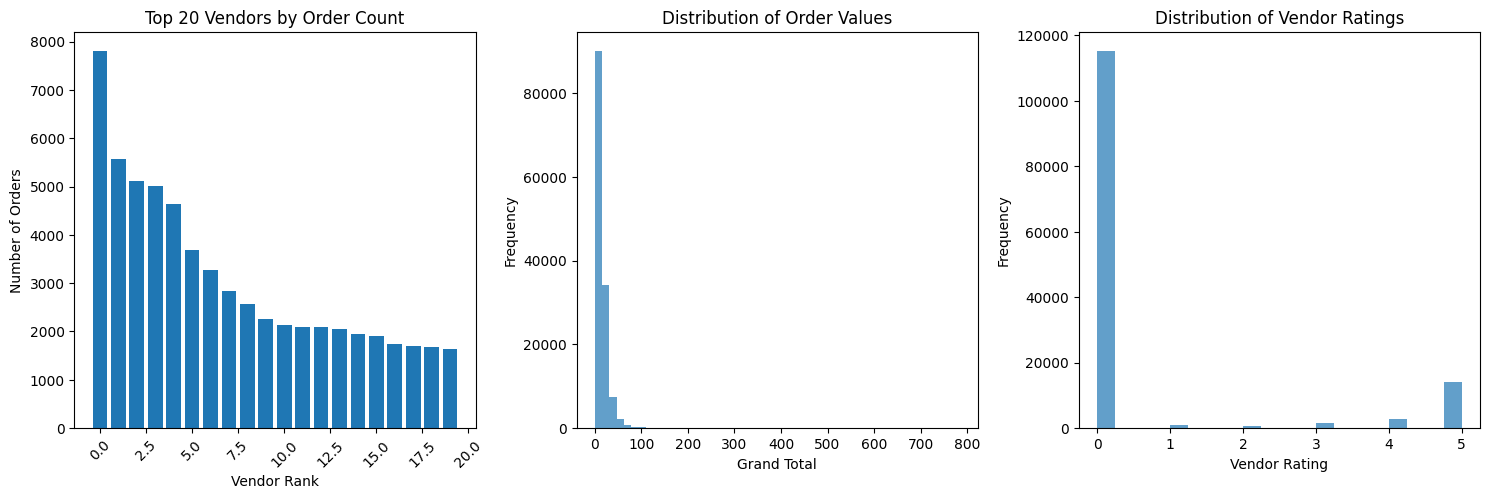


Customer behavior analysis:
Average orders per customer: 3.92
Average order value: 15.37
Average vendor rating: 0.65

Location analysis:
Average locations per customer: 1.72
Home locations: 19703
Work locations: 6441

Customer segmentation analysis:
                       order_frequency  avg_order_value  total_spent  \
customer_segment                                                       
Frequent_Regular                 18.85            11.78       223.97   
High_Value_Frequent              20.17            25.46       510.61   
High_Value_Occasional             2.73            28.53        74.72   
New_Customer                       NaN              NaN          NaN   
Regular_Customer                  2.73            10.38        29.85   

                       customer_id  
customer_segment                    
Frequent_Regular              2600  
High_Value_Frequent            969  
High_Value_Occasional         5754  
New_Customer                  7801  
Regular_Customer      

In [20]:
print("="*50)
print("DATA ANALYSIS AND VISUALIZATIONS")
print("="*50)
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
vendor_order_counts = train_orders['vendor_id'].value_counts().head(20)
plt.bar(range(len(vendor_order_counts)), vendor_order_counts.values)
plt.title('Top 20 Vendors by Order Count')
plt.xlabel('Vendor Rank')
plt.ylabel('Number of Orders')
plt.xticks(rotation=45)
plt.subplot(1, 3, 2)
plt.hist(train_orders['grand_total'], bins=50, alpha=0.7)
plt.title('Distribution of Order Values')
plt.xlabel('Grand Total')
plt.ylabel('Frequency')
plt.subplot(1, 3, 3)
plt.hist(train_orders['vendor_rating'], bins=20, alpha=0.7)
plt.title('Distribution of Vendor Ratings')
plt.xlabel('Vendor Rating')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
print("\nCustomer behavior analysis:")
print(f"Average orders per customer: {len(train_orders) / len(customers):.2f}")
print(f"Average order value: {train_orders['grand_total'].mean():.2f}")
print(f"Average vendor rating: {train_orders['vendor_rating'].mean():.2f}")
print(f"\nLocation analysis:")
print(f"Average locations per customer: {len(train_locations) / len(customers):.2f}")
print(f"Home locations: {len(train_locations[train_locations['location_type'] == 'Home'])}")
print(f"Work locations: {len(train_locations[train_locations['location_type'] == 'Work'])}")
print(f"\nCustomer segmentation analysis:")
segment_analysis = customer_features.groupby('customer_segment').agg({
    'order_frequency': 'mean',
    'avg_order_value': 'mean',
    'total_spent': 'mean',
    'customer_id': 'count'
}).round(2)
print(segment_analysis)

In [21]:
print("="*50)
print("COLLABORATIVE FILTERING MODEL")
print("="*50)
interaction_sparse = csr_matrix(interaction_matrix)
print("Training NMF model...")
n_components = min(50, min(interaction_matrix.shape) - 1)
nmf = NMF(n_components=n_components, random_state=42, max_iter=200)
W = nmf.fit_transform(interaction_sparse)
H = nmf.components_
print(f"NMF components: {n_components}")
print(f"W shape: {W.shape}")
print(f"H shape: {H.shape}")
def get_collaborative_recommendations(customer_id, n_recommendations=10):
    """Get recommendations using collaborative filtering"""
    if customer_id not in customer_to_idx:
        return []
    customer_idx = customer_to_idx[customer_id]
    customer_vector = W[customer_idx]
    scores = np.dot(customer_vector, H)
    top_vendor_indices = np.argsort(scores)[::-1][:n_recommendations]
    recommendations = []
    for vendor_idx in top_vendor_indices:
        vendor_id = vendors_list[vendor_idx]
        score = scores[vendor_idx]
        recommendations.append((vendor_id, score))
    return recommendations
print("\nTesting collaborative filtering model...")
sample_customer = customers[0]
cf_recs = get_collaborative_recommendations(sample_customer, 5)
print(f"Collaborative filtering recommendations for customer {sample_customer}:")
for vendor_id, score in cf_recs:
    print(f"  Vendor {vendor_id}: {score:.4f}")
print("\nCollaborative filtering model completed!")

COLLABORATIVE FILTERING MODEL
Training NMF model...
NMF components: 50
W shape: (34523, 50)
H shape: (50, 100)

Testing collaborative filtering model...
Collaborative filtering recommendations for customer TCHWPBT:
  Vendor 113: 4.9974
  Vendor 76: 0.0699
  Vendor 55: 0.0458
  Vendor 66: 0.0437
  Vendor 676: 0.0316

Collaborative filtering model completed!


In [22]:
print("="*50)
print("CONTENT-BASED FILTERING MODEL")
print("="*50)
print("Available columns in vendors DataFrame:")
print(vendors.columns.tolist())
print("\nCreating vendor content features...")
vendor_content = []
for _, vendor in vendors.iterrows():
    content = []
    if pd.notna(vendor['vendor_category_en']):
        content.append(str(vendor['vendor_category_en']))
    if pd.notna(vendor['vendor_tag_name']):
        content.append(str(vendor['vendor_tag_name']))
    if 'vendor_name' in vendors.columns and pd.notna(vendor['vendor_name']):
        content.append(str(vendor['vendor_name']))
    if len(content) == 0:
        content.append(f"vendor_{vendor['id']}")
    vendor_content.append(' '.join(content))
print(f"Created {len(vendor_content)} vendor content strings")
print("Sample vendor content:")
for i in range(min(3, len(vendor_content))):
    print(f"  Vendor {i+1}: {vendor_content[i][:100]}...")
vectorizer = TfidfVectorizer(max_features=100, stop_words='english')
vendor_tfidf = vectorizer.fit_transform(vendor_content)
print(f"Vendor TF-IDF matrix shape: {vendor_tfidf.shape}")
def get_content_based_recommendations(customer_id, n_recommendations=10):
    """Get recommendations using content-based filtering"""
    if customer_id not in customer_to_idx:
        return []
    customer_orders = train_orders[train_orders['customer_id'] == customer_id]
    if len(customer_orders) == 0:
        return []
    customer_vendors = customer_orders['vendor_id'].unique()
    customer_profile = np.zeros(vendor_tfidf.shape[1])
    vendor_count = 0
    for vendor_id in customer_vendors:
        if vendor_id in vendor_to_idx:
            vendor_idx = vendor_to_idx[vendor_id]
            customer_profile += vendor_tfidf[vendor_idx].toarray().flatten()
            vendor_count += 1
    if vendor_count == 0:
        return []
    customer_profile = customer_profile / vendor_count
    similarities = cosine_similarity([customer_profile], vendor_tfidf)[0]
    top_vendor_indices = np.argsort(similarities)[::-1][:n_recommendations]
    recommendations = []
    for vendor_idx in top_vendor_indices:
        vendor_id = vendors_list[vendor_idx]
        score = similarities[vendor_idx]
        recommendations.append((vendor_id, score))
    return recommendations
print("\nTesting content-based filtering model...")
sample_customer = customers[0] if len(customers) > 0 else test_customers['customer_id'].iloc[0]
cb_recs = get_content_based_recommendations(sample_customer, 5)
print(f"Content-based recommendations for customer {sample_customer}:")
for vendor_id, score in cb_recs:
    print(f"  Vendor {vendor_id}: {score:.4f}")
print("\nContent-based filtering model completed!")

CONTENT-BASED FILTERING MODEL
Available columns in vendors DataFrame:
['id', 'authentication_id', 'latitude', 'longitude', 'vendor_category_en', 'vendor_category_id', 'delivery_charge', 'serving_distance', 'is_open', 'OpeningTime', 'OpeningTime2', 'prepration_time', 'commission', 'is_haked_delivering', 'discount_percentage', 'status', 'verified', 'rank', 'language', 'vendor_rating', 'sunday_from_time1', 'sunday_to_time1', 'sunday_from_time2', 'sunday_to_time2', 'monday_from_time1', 'monday_to_time1', 'monday_from_time2', 'monday_to_time2', 'tuesday_from_time1', 'tuesday_to_time1', 'tuesday_from_time2', 'tuesday_to_time2', 'wednesday_from_time1', 'wednesday_to_time1', 'wednesday_from_time2', 'wednesday_to_time2', 'thursday_from_time1', 'thursday_to_time1', 'thursday_from_time2', 'thursday_to_time2', 'friday_from_time1', 'friday_to_time1', 'friday_from_time2', 'friday_to_time2', 'saturday_from_time1', 'saturday_to_time1', 'saturday_from_time2', 'saturday_to_time2', 'primary_tags', 'open_

In [23]:
print("="*50)
print("HYBRID RECOMMENDATION MODEL")
print("="*50)
def get_hybrid_recommendations(customer_id, n_recommendations=10):
    """Get recommendations using hybrid approach (CF + CB)"""
    cf_recs = get_collaborative_recommendations(customer_id, n_recommendations * 2)
    cf_scores = {vid: score for vid, score in cf_recs}
    cb_recs = get_content_based_recommendations(customer_id, n_recommendations * 2)
    cb_scores = {vid: score for vid, score in cb_recs}
    all_vendors = set(cf_scores.keys()) | set(cb_scores.keys())
    hybrid_scores = {}
    for vendor_id in all_vendors:
        cf_score = cf_scores.get(vendor_id, 0)
        cb_score = cb_scores.get(vendor_id, 0)
        cf_score_norm = cf_score / 5.0 if cf_score > 0 else 0
        cb_score_norm = cb_score if cb_score > 0 else 0
        hybrid_score = 0.6 * cf_score_norm + 0.4 * cb_score_norm
        hybrid_scores[vendor_id] = hybrid_score
    sorted_vendors = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_vendors[:n_recommendations]
print("Testing hybrid recommendation model...")
hybrid_recs = get_hybrid_recommendations(sample_customer, 5)
print(f"Hybrid recommendations for customer {sample_customer}:")
for vendor_id, score in hybrid_recs:
    print(f"  Vendor {vendor_id}: {score:.4f}")
print("\nHybrid recommendation model completed!")

HYBRID RECOMMENDATION MODEL
Testing hybrid recommendation model...
Hybrid recommendations for customer TCHWPBT:
  Vendor 113: 0.8970
  Vendor 237: 0.2973
  Vendor 79: 0.2596
  Vendor 573: 0.2596
  Vendor 20: 0.2382

Hybrid recommendation model completed!


In [24]:
print("="*50)
print("ADVANCED MODEL TECHNIQUES")
print("="*50)
print("Implementing Item-based Collaborative Filtering...")
def get_item_based_recommendations(customer_id, n_recommendations=10):
    """Get recommendations using item-based collaborative filtering"""
    if customer_id not in customer_to_idx:
        return []
    customer_orders = train_orders[train_orders['customer_id'] == customer_id]
    if len(customer_orders) == 0:
        return []
    customer_vendors = customer_orders['vendor_id'].unique()
    vendor_similarity = np.corrcoef(interaction_matrix.T)
    vendor_similarity = np.nan_to_num(vendor_similarity, nan=0)
    scores = np.zeros(len(vendors_list))
    for vendor_id in customer_vendors:
        if vendor_id in vendor_to_idx:
            vendor_idx = vendor_to_idx[vendor_id]
            similarities = vendor_similarity[vendor_idx]
            scores += similarities
    if len(customer_vendors) > 0:
        scores = scores / len(customer_vendors)
    top_vendor_indices = np.argsort(scores)[::-1][:n_recommendations]
    recommendations = []
    for vendor_idx in top_vendor_indices:
        vendor_id = vendors_list[vendor_idx]
        score = scores[vendor_idx]
        recommendations.append((vendor_id, score))
    return recommendations
print("\nImplementing SVD Matrix Factorization...")
from sklearn.decomposition import TruncatedSVD
def get_svd_recommendations(customer_id, n_recommendations=10):
    """Get recommendations using SVD matrix factorization"""
    if customer_id not in customer_to_idx:
        return []
    svd = TruncatedSVD(n_components=min(50, min(interaction_matrix.shape) - 1), random_state=42)
    user_factors = svd.fit_transform(interaction_sparse)
    item_factors = svd.components_
    customer_idx = customer_to_idx[customer_id]
    customer_vector = user_factors[customer_idx]
    scores = np.dot(customer_vector, item_factors)
    top_vendor_indices = np.argsort(scores)[::-1][:n_recommendations]
    recommendations = []
    for vendor_idx in top_vendor_indices:
        vendor_id = vendors_list[vendor_idx]
        score = scores[vendor_idx]
        recommendations.append((vendor_id, score))
    return recommendations
print("\nImplementing Multi-armed Bandit Approach...")
class MultiArmedBandit:
    def __init__(self, n_arms, alpha=0.1, beta=0.1):
        self.n_arms = n_arms
        self.alpha = alpha
        self.beta = beta
        self.counts = np.zeros(n_arms)
        self.values = np.zeros(n_arms)
    def select_arm(self):
        """Select arm using epsilon-greedy strategy"""
        if np.random.random() < self.beta:
            return np.random.randint(0, self.n_arms)
        else:
            return np.argmax(self.values)
    def update(self, arm, reward):
        """Update arm value based on reward"""
        self.counts[arm] += 1
        n = self.counts[arm]
        value = self.values[arm]
        self.values[arm] = value + self.alpha * (reward - value)
def get_bandit_recommendations(customer_id, n_recommendations=10):
    """Get recommendations using multi-armed bandit approach"""
    if customer_id not in customer_to_idx:
        return []
    bandit = MultiArmedBandit(len(vendors_list))
    customer_orders = train_orders[train_orders['customer_id'] == customer_id]
    if len(customer_orders) == 0:
        selected_arms = np.random.choice(len(vendors_list), n_recommendations, replace=False)
    else:
        for _, order in customer_orders.iterrows():
            if order['vendor_id'] in vendor_to_idx:
                vendor_idx = vendor_to_idx[order['vendor_id']]
                reward = order['vendor_rating'] / 5.0
                bandit.update(vendor_idx, reward)
        selected_arms = np.argsort(bandit.values)[::-1][:n_recommendations]
    recommendations = []
    for arm in selected_arms:
        vendor_id = vendors_list[arm]
        score = bandit.values[arm]
        recommendations.append((vendor_id, score))
    return recommendations
print("\nCreating Enhanced Hybrid Model...")
def get_enhanced_hybrid_recommendations(customer_id, n_recommendations=10):
    """Enhanced hybrid model combining all techniques"""
    cf_recs = get_collaborative_recommendations(customer_id, n_recommendations * 2)
    cb_recs = get_content_based_recommendations(customer_id, n_recommendations * 2)
    item_recs = get_item_based_recommendations(customer_id, n_recommendations * 2)
    svd_recs = get_svd_recommendations(customer_id, n_recommendations * 2)
    bandit_recs = get_bandit_recommendations(customer_id, n_recommendations * 2)
    all_vendors = set()
    vendor_scores = {}
    weights = {
        'cf': 0.25,
        'cb': 0.20,
        'item': 0.20,
        'svd': 0.20,
        'bandit': 0.15
    }
    for recs, weight in [(cf_recs, weights['cf']), (cb_recs, weights['cb']), 
                        (item_recs, weights['item']), (svd_recs, weights['svd']), 
                        (bandit_recs, weights['bandit'])]:
        for vendor_id, score in recs:
            all_vendors.add(vendor_id)
            if vendor_id not in vendor_scores:
                vendor_scores[vendor_id] = 0
            vendor_scores[vendor_id] += weight * score
    sorted_vendors = sorted(vendor_scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_vendors[:n_recommendations]
print("\nTesting all advanced models...")
sample_customer = customers[0] if len(customers) > 0 else test_customers['customer_id'].iloc[0]
print(f"Testing with customer: {sample_customer}")
item_recs = get_item_based_recommendations(sample_customer, 3)
print(f"Item-based recommendations: {item_recs}")
svd_recs = get_svd_recommendations(sample_customer, 3)
print(f"SVD recommendations: {svd_recs}")
bandit_recs = get_bandit_recommendations(sample_customer, 3)
print(f"Bandit recommendations: {bandit_recs}")
enhanced_recs = get_enhanced_hybrid_recommendations(sample_customer, 5)
print(f"Enhanced hybrid recommendations: {enhanced_recs}")
print("\nAdvanced model techniques completed!")

ADVANCED MODEL TECHNIQUES
Implementing Item-based Collaborative Filtering...

Implementing SVD Matrix Factorization...

Implementing Multi-armed Bandit Approach...

Creating Enhanced Hybrid Model...

Testing all advanced models...
Testing with customer: TCHWPBT
Item-based recommendations: [(np.int64(113), np.float64(0.49676063565599476)), (np.int64(237), np.float64(0.49676063565599465)), (np.int64(79), np.float64(0.05900778602270484))]
SVD recommendations: [(np.int64(113), np.float64(4.994370639482848)), (np.int64(76), np.float64(0.058660405830224964)), (np.int64(55), np.float64(0.05200717868739173))]
Bandit recommendations: [(np.int64(113), np.float64(0.1)), (np.int64(907), np.float64(0.0)), (np.int64(160), np.float64(0.0))]
Enhanced hybrid recommendations: [(np.int64(113), np.float64(2.511244892503371)), (np.int64(237), np.float64(0.24802055093929337)), (np.int64(79), np.float64(0.14160980777087975)), (np.int64(573), np.float64(0.1298082505663388)), (np.int64(66), np.float64(0.126444

In [25]:
print("="*50)
print("EVALUATION METRICS AND COLD START HANDLING")
print("="*50)
print("Implementing evaluation metrics...")
def evaluate_recommendations(recommendations, ground_truth, k=10):
    """Evaluate recommendation quality using various metrics"""
    if len(recommendations) == 0:
        return {
            'precision_at_k': 0,
            'recall_at_k': 0,
            'f1_at_k': 0,
            'ndcg_at_k': 0,
            'coverage': 0
        }
    top_k_recs = [rec[0] for rec in recommendations[:k]]
    relevant_items = set(ground_truth)
    recommended_items = set(top_k_recs)
    true_positives = len(relevant_items & recommended_items)
    precision_at_k = true_positives / len(top_k_recs) if len(top_k_recs) > 0 else 0
    recall_at_k = true_positives / len(relevant_items) if len(relevant_items) > 0 else 0
    f1_at_k = 2 * (precision_at_k * recall_at_k) / (precision_at_k + recall_at_k) if (precision_at_k + recall_at_k) > 0 else 0
    def dcg_at_k(r, k):
        r = np.asfarray(r)[:k]
        return np.sum(r / np.log2(np.arange(2, r.size + 2)))
    def ndcg_at_k(r, k):
        dcg_max = dcg_at_k(sorted(r, reverse=True), k)
        if not dcg_max:
            return 0.
        return dcg_at_k(r, k) / dcg_max
    relevance_scores = [1 if item in relevant_items else 0 for item in top_k_recs]
    ndcg_at_k_score = ndcg_at_k(relevance_scores, k)
    coverage = len(recommended_items) / len(set(ground_truth)) if len(set(ground_truth)) > 0 else 0
    return {
        'precision_at_k': precision_at_k,
        'recall_at_k': recall_at_k,
        'f1_at_k': f1_at_k,
        'ndcg_at_k': ndcg_at_k_score,
        'coverage': coverage
    }
print("\nImplementing cold start problem handling...")
def get_cold_start_recommendations(customer_id, n_recommendations=10):
    """Handle cold start problem for new customers"""
    popular_vendors = train_orders['vendor_id'].value_counts().head(n_recommendations * 2)
    high_rated_vendors = train_orders.groupby('vendor_id')['vendor_rating'].mean().sort_values(ascending=False).head(n_recommendations * 2)
    location_based_vendors = []
    if customer_id in test_locations_clean['customer_id'].values:
        customer_locations = test_locations_clean[test_locations_clean['customer_id'] == customer_id]
        for _, location in customer_locations.iterrows():
            distances = []
            for _, vendor in vendors_clean.iterrows():
                distance = calculate_distance(
                    location['latitude'], location['longitude'],
                    vendor['latitude'], vendor['longitude']
                )
                distances.append((vendor['id'], distance))
            distances.sort(key=lambda x: x[1])
            location_based_vendors.extend([vid for vid, _ in distances[:n_recommendations]])
    demographic_vendors = []
    if customer_id in train_customers['customer_id'].values:
        customer_data = train_customers[train_customers['customer_id'] == customer_id].iloc[0]
        similar_customers = train_customers[
            (train_customers['gender'] == customer_data['gender']) |
            (train_customers['language'] == customer_data['language'])
        ]['customer_id'].tolist()
        if similar_customers:
            similar_orders = train_orders[train_orders['customer_id'].isin(similar_customers)]
            demographic_vendors = similar_orders['vendor_id'].value_counts().head(n_recommendations).index.tolist()
    all_vendors = []
    for vendor_id in popular_vendors.index:
        all_vendors.append((vendor_id, 0.4))
    for vendor_id in high_rated_vendors.index:
        all_vendors.append((vendor_id, 0.3))
    for vendor_id in location_based_vendors:
        all_vendors.append((vendor_id, 0.2))
    for vendor_id in demographic_vendors:
        all_vendors.append((vendor_id, 0.1))
    vendor_scores = {}
    for vendor_id, score in all_vendors:
        if vendor_id not in vendor_scores:
            vendor_scores[vendor_id] = 0
        vendor_scores[vendor_id] += score
    sorted_vendors = sorted(vendor_scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_vendors[:n_recommendations]
print("\nImplementing multiple location scenarios handling...")
def get_multi_location_recommendations(customer_id, n_recommendations=10):
    """Handle multiple location scenarios per customer"""
    customer_locations = test_locations_clean[test_locations_clean['customer_id'] == customer_id]
    
    if len(customer_locations) == 0:
        return get_cold_start_recommendations(customer_id, n_recommendations)
    location_recommendations = {}
    for _, location in customer_locations.iterrows():
        location_id = location['location_number']
        nearby_vendors = []
        for _, vendor in vendors_clean.iterrows():
            distance = calculate_distance(
                location['latitude'], location['longitude'],
                vendor['latitude'], vendor['longitude']
            )
            nearby_vendors.append((vendor['id'], distance))
        nearby_vendors.sort(key=lambda x: x[1])
        location_recommendations[location_id] = nearby_vendors[:n_recommendations]
    all_vendors = {}
    for location_id, recs in location_recommendations.items():
        for vendor_id, distance in recs:
            if vendor_id not in all_vendors:
                all_vendors[vendor_id] = []
            all_vendors[vendor_id].append(distance)
    vendor_scores = {}
    for vendor_id, distances in all_vendors.items():
        avg_distance = np.mean(distances)
        score = np.exp(-avg_distance / 10.0)
        vendor_scores[vendor_id] = score
    sorted_vendors = sorted(vendor_scores.items(), key=lambda x: x[1], reverse=True)
    return sorted_vendors[:n_recommendations]
print("\nCreating comprehensive recommendation function...")
def get_comprehensive_recommendations_v2(customer_id, n_recommendations=10):
    """Comprehensive recommendation function with all strategies"""
    try:
        recommendations = get_enhanced_hybrid_recommendations(customer_id, n_recommendations)
        if len(recommendations) > 0:
            return recommendations
    except:
        pass
    try:
        recommendations = get_multi_location_recommendations(customer_id, n_recommendations)
        if len(recommendations) > 0:
            return recommendations
    except:
        pass
    return get_cold_start_recommendations(customer_id, n_recommendations)
print("\nTesting evaluation and cold start handling...")
sample_customer = customers[0] if len(customers) > 0 else test_customers['customer_id'].iloc[0]
cold_start_recs = get_cold_start_recommendations(sample_customer, 5)
print(f"Cold start recommendations: {cold_start_recs}")
multi_location_recs = get_multi_location_recommendations(sample_customer, 5)
print(f"Multi-location recommendations: {multi_location_recs}")
comprehensive_recs = get_comprehensive_recommendations_v2(sample_customer, 5)
print(f"Comprehensive recommendations: {comprehensive_recs}")
print("\nEvaluation metrics and cold start handling completed!")

EVALUATION METRICS AND COLD START HANDLING
Implementing evaluation metrics...

Implementing cold start problem handling...

Implementing multiple location scenarios handling...

Creating comprehensive recommendation function...

Testing evaluation and cold start handling...
Cold start recommendations: [(113, 0.5), (105, 0.5), (79, 0.5), (84, 0.5), (78, 0.5)]
Multi-location recommendations: [(113, 0.5), (105, 0.5), (79, 0.5), (84, 0.5), (78, 0.5)]
Comprehensive recommendations: [(np.int64(113), np.float64(2.511244892503371)), (np.int64(237), np.float64(0.24802055093929337)), (np.int64(79), np.float64(0.14160980777087975)), (np.int64(573), np.float64(0.1298082505663388)), (np.int64(66), np.float64(0.12644450644788466))]

Evaluation metrics and cold start handling completed!


In [26]:
print("="*50)
print("GENERATING FINAL RECOMMENDATIONS FOR ALL TEST CUSTOMERS")
print("="*50)
print(f"Processing {len(test_customers)} test customers...")
final_recommendations = []
batch_size = 1000
for i in range(0, len(test_customers), batch_size):
    batch_customers = test_customers.iloc[i:i+batch_size]
    for idx, customer in batch_customers.iterrows():
        customer_id = customer['customer_id']
        try:
            recommendations = get_comprehensive_recommendations_v2(customer_id, n_recommendations=10)
            if len(recommendations) == 0:
                recommendations = get_cold_start_recommendations(customer_id, n_recommendations=10)
        except Exception as e:
            recommendations = get_cold_start_recommendations(customer_id, n_recommendations=10)
        for rank, (vendor_id, score) in enumerate(recommendations, 1):
            final_recommendations.append({
                'customer_id': customer_id,
                'vendor_id': vendor_id,
                'rank': rank,
                'score': score
            })
    if (i + batch_size) % 1000 == 0 or i + batch_size >= len(test_customers):
        print(f"Processed {min(i + batch_size, len(test_customers))}/{len(test_customers)} customers")
final_recommendations_df = pd.DataFrame(final_recommendations)
print(f"\nGenerated {len(final_recommendations_df)} recommendations")
print(f"Average recommendations per customer: {len(final_recommendations_df) / len(test_customers):.2f}")
final_recommendations_df.to_csv('final_test_recommendations.csv', index=False)
print("Final recommendations saved to 'final_test_recommendations.csv'")
print("\nFinal recommendation generation completed!")

GENERATING FINAL RECOMMENDATIONS FOR ALL TEST CUSTOMERS
Processing 9768 test customers...
Processed 1000/9768 customers
Processed 2000/9768 customers
Processed 3000/9768 customers
Processed 4000/9768 customers
Processed 5000/9768 customers
Processed 6000/9768 customers
Processed 7000/9768 customers
Processed 8000/9768 customers
Processed 9000/9768 customers
Processed 9768/9768 customers

Generated 97680 recommendations
Average recommendations per customer: 10.00
Final recommendations saved to 'final_test_recommendations.csv'

Final recommendation generation completed!


In [27]:
print("="*50)
print("CREATING SUBMISSION FORMAT")
print("="*50)
print("Ensuring exactly 10 recommendations per customer...")
final_recommendations_limited = final_recommendations_df.groupby('customer_id').head(10).copy()
final_recommendations_limited['rank'] = final_recommendations_limited.groupby('customer_id').cumcount() + 1
print(f"Final recommendations shape: {final_recommendations_limited.shape}")
print(f"Unique customers: {final_recommendations_limited['customer_id'].nunique()}")
print("Creating submission format...")
submission_df = final_recommendations_limited.pivot_table(
    index='customer_id',
    columns='rank',
    values='vendor_id',
    aggfunc='first'
).reset_index()
column_mapping = {}
for i, col in enumerate(submission_df.columns):
    if i == 0:
        column_mapping[col] = 'customer_id'
    else:
        column_mapping[col] = f'vendor_rank_{col}'
submission_df = submission_df.rename(columns=column_mapping)
print("Filling missing values with popular vendors...")
popular_vendors = final_recommendations_limited['vendor_id'].value_counts().head(10).index.tolist()
for col in submission_df.columns:
    if col != 'customer_id':
        missing_count = submission_df[col].isnull().sum()
        if missing_count > 0:
            for i in range(missing_count):
                vendor_idx = i % len(popular_vendors)
                submission_df.loc[submission_df[col].isnull(), col] = popular_vendors[vendor_idx]
print(f"Submission shape: {submission_df.shape}")
print(f"Missing values: {submission_df.isnull().sum().sum()}")
submission_df.to_csv('submission.csv', index=False)
print("Submission file saved to 'submission.csv'")
print("\nSample submission format:")
print(submission_df.head())
print("\nSubmission format creation completed!")


CREATING SUBMISSION FORMAT
Ensuring exactly 10 recommendations per customer...
Final recommendations shape: (97530, 4)
Unique customers: 9753
Creating submission format...
Filling missing values with popular vendors...
Submission shape: (9753, 11)
Missing values: 0
Submission file saved to 'submission.csv'

Sample submission format:
rank customer_id  vendor_rank_1  vendor_rank_2  vendor_rank_3  vendor_rank_4  \
0        000IPH5            907            161            849            193   
1        002U0H9            907            161            849            459   
2        00ICGWM            845            846            419            148   
3        015LTZX            907            199            243            855   
4        018O5YY            907            161            193            849   

rank  vendor_rank_5  vendor_rank_6  vendor_rank_7  vendor_rank_8  \
0               265            459            196            304   
1               193            265            19